In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import math
from datetime import datetime
# import warnings
# warnings.filterwarnings("error")

In [4]:
import sys, os
script_dir = sys.path[0]
print(script_dir)

DATA_PATH = os.path.join(script_dir+r'\train\train\7554\SimpleTest')
print(DATA_PATH)

D:\Data_science_project\Project\data visualization project\pandas project
D:\Data_science_project\Project\data visualization project\pandas project\train\train\7554\SimpleTest


# Preprocessing

In [3]:
for d in [d for d in os.listdir(script_dir+r'\train\train') if not d.startswith('.')]:
    d_path = os.path.join(script_dir+r'\train\train\{}\SimpleTest')
    for f in os.listdir(d_path.format(d)):
        if(f.endswith('.csv') and not f.startswith('Test Time Log')):
            f_path = d_path.format(d)
            data = pd.read_csv(f_path + '/' + f)
            data['Color'] = 0
            data.dropna(axis = 0, inplace = True)
            data = data.astype({'X' : float})
            data.rename(columns = {" Y" : "Y", 
                                    " Pressure" : "Pressure", 
                                    " TiltX" : "TiltX", 
                                    " TiltY" : "TiltY", 
                                    " Time" : "Time"}, inplace = True)
#             data['Time']=data['Time'].apply(lambda x: float(x.split(':')[0])*60+float(x.split(':')[1]))
            data.to_csv(f_path + '/' + f, index=False)

# Coding time

In [104]:
##Function zone
def plot_images(path):
    counter = 0
    for f in os.listdir(path):
        file_path = os.path.join(path+'\\'+f)
        if(f.split(".")[1] == "csv" and f != "Test Time Log.csv"):
            counter += 1
                
    fig, ax = plt.subplots(counter,2)
    fig.set_figheight(150)
    fig.set_figwidth(15)
    index = 0
    
    print("Plotting {0} images".format(counter))
    for f in os.listdir(path):
        file_path = os.path.join(path+'\\'+f)
        if(f.split(".")[1] == "csv" and f != "Test Time Log.csv"):
            data = pd.read_csv(file_path)
            #Plot picture
            ax[index,0].scatter(data['X'], data['Y'])
            ax[index,0].set_title(f + " (Image)")
            ax[index,0].set_xlabel('X')
            ax[index,0].set_ylabel('Y')
            ax[index,0].set_xlim(data['X'].min()-50, data['X'].max()+50)
            ax[index,0].set_ylim(data['Y'].min()-50, data['Y'].max()+100)
            ax[index,0].invert_yaxis()
            
            ndata = data[data['Color'] != 0]
            ax[index,1].scatter(x=ndata['X'], y=ndata['Y'], c=ndata['Color'], cmap='gist_rainbow')
            ax[index,1].set_title(f + " (Image Colored lines)")
            ax[index,1].set_xlabel('X')
            ax[index,1].set_ylabel('Y')
            ax[index,1].set_xlim(data['X'].min()-50, data['X'].max()+50)
            ax[index,1].set_ylim(data['Y'].min()-50, data['Y'].max()+100)
            ax[index,1].invert_yaxis()
            
            
            #Plot pressure
#             ax[index,1].plot(data.index, data['Pressure'])
#             ax[index,1].set_title(f + " (Pressure)")
#             ax[index,1].set_ylabel('Pressure')
#             ax[1,index].set_xlim(data['X'].min()-50, data['X'].max()+50)
#             ax[1,index].set_ylim(data['Pressure'].min()-50, data['Pressure'].max()+100)
            index += 1
      
def calc_pen_raises(path, time_epsilo):
    result = {}
    for f in os.listdir(path):
        file_path = os.path.join(path+'\\'+f)
        if(f.split(".")[1] == "csv" and f != "Test Time Log.csv"):
            data = pd.read_csv(file_path)
            lift_count = 0
            for index in (data.index[:-1]):
                if(data["Time"][index+1] - data["Time"][index] > time_epsilo):
                    lift_count += 1
            result[f.split(".")[0]] = lift_count
            
    plt.figure(figsize=(15,10))
    plt.bar(range(len(result)), list(result.values()), align='center')
    plt.xlabel("CSV file number")
    plt.ylabel("Number of pen raises")
    plt.grid()
    plt.xticks(range(len(result)), list(result.keys()))
    
def calc_lines1(path):
    result = {}
    for f in os.listdir(path):
        file_path = os.path.join(path+'\\'+f)
        if(f.split(".")[1] == "csv" and f != "Test Time Log.csv"):
            data = pd.read_csv(file_path)
            
            dot_count = 0
            pressure_sum = 0
            length = 0
            properties = {}
            line_count = 0
            property_list = []
            colors = [0]
            for index in (data.index[:-1]):
                colors.append(line_count)
                if((data["TiltX"][index] == data["TiltX"][index+1]) and (data["TiltY"][index] == data["TiltY"][index+1])):
                    flag = True #Is a part of a line
                    dot_count += 1
                    pressure_sum += data['Pressure'][index]
                    length += math.sqrt(math.pow(data["X"][index] - data["X"][index+1],2) + math.pow(data["Y"][index] - data["Y"][index+1],2))
                else:
                    if(flag and (length >= 50)):
                        dot_count += 1
                        pressure_sum += data['Pressure'][index]
                        pressure_avg = pressure_sum / dot_count
                        line_count += 1
                        property_list.append(pressure_avg)
                        property_list.append(length)
                        properties[line_count] = property_list
                    dot_count = 0
                    pressure_sum = 0
                    length = 0
                    property_list = []
                    flag = False
            
            data['Color'] = colors
            data.to_csv(file_path, index=False)
            result[f.split(".")[0]] = properties
            
    pprint.pprint(result)

def calc_lines2(path, time_epsilo, length_epsilo):
    result = {}
    for f in os.listdir(path):
        file_path = os.path.join(path+'\\'+f)
        if(f.endswith(".csv") and f != "Test Time Log.csv"):
            
            data = pd.read_csv(file_path)
            colors = np.zeros((data['Color'].size,), dtype=int)
            line_count = 1
            length = 0
            line_start = 0
            
            for index in (data.index[:-1]):
                if(data["Time"][index+1] - data["Time"][index] > time_epsilo):
                    if(length > length_epsilo):
                        for i in range(line_start, index+1):
                            colors[i] = line_count
                        line_count += 1
                    line_start = index+1
                    length = 0
                else:
                    length += math.sqrt(math.pow(data["X"][index] - data["X"][index+1],2) + math.pow(data["Y"][index] - data["Y"][index+1],2))
            
            if(length > length_epsilo): # check last line
                for i in range(line_start, index+2):
                    colors[i] = line_count
            if(np.all((colors==0))):
                line_count = 0
            data['Color'] = colors
            data.to_csv(file_path, index=False)
            result[f.split(".")[0]] = line_count
            
    return result
    
# def calc_lines3(path, epsilo):
#     result = {}
#     for f in os.listdir(path):
#         file_path = os.path.join(path+'\\'+f)
#         if(f.split(".")[1] == "csv" and f != "Test Time Log.csv"):
#             data = pd.read_csv(file_path)
#             dot_count = 0
#             pressure_sum = 0
#             length = 0
#             properties = {}
#             line_count = 0
#             property_list = []
#             colors = [0]
#             m_init = (data['Y'][1] - data['Y'][0]) / (data['X'][1] - data['X'][0] + 0.001)
#             flag = False
#             for index in (data.index[:-1]):
#                 colors.append(line_count)
#                 m_iter = (data['Y'][index+1] - data['Y'][index]) / (data['X'][index+1] - data['X'][index] + 0.001)
#                 if(abs(m_iter - m_init) < epsilo):
#                     flag = True #Is a part of a line
#                     dot_count += 1
#                     pressure_sum += data['Pressure'][index]
#                     length += math.sqrt(math.pow(data["X"][index] - data["X"][index+1],2) + math.pow(data["Y"][index] - data["Y"][index+1],2))
#                 else:
#                     if(flag and length >= 50):
#                         dot_count += 1
#                         pressure_sum += data['Pressure'][index]
#                         pressure_avg = pressure_sum / dot_count
#                         line_count += 1
#                         property_list.append(pressure_avg)
#                         property_list.append(length)
#                         properties[line_count] = property_list
#                     dot_count = 0
#                     pressure_sum = 0
#                     length = 0
#                     property_list = []
#                     flag = False
#                     m_init = m_iter
#                 #print(flag)
            
#             data['Color'] = colors
#             data.to_csv(file_path, index=False)
#             result[f.split(".")[0]] = properties
# #     pprint.pprint(result)
    

In [105]:
print(calc_lines2(DATA_PATH, 0.1, 10))

{'1': 1, '10': 8, '11': 6, '12': 4, '13': 5, '14': 8, '15': 6, '16': 4, '17': 2, '18': 12, '19': 8, '2': 1, '20': 4, '21': 7, '3': 1, '4': 1, '5': 3, '6': 1, '7': 0, '8': 3, '9': 6}


Plotting 21 images


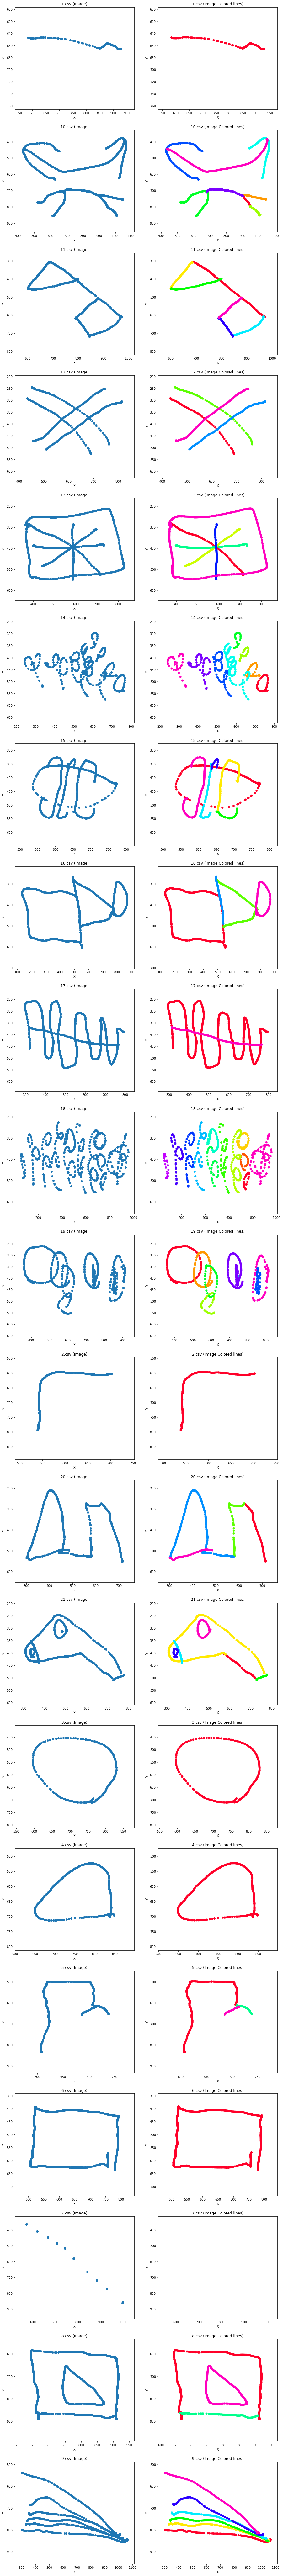

In [106]:
plot_images(DATA_PATH)

(0.0, 889.934634484351)

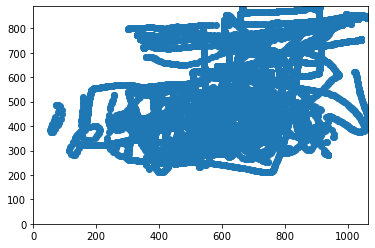

In [113]:
plt.scatter(data['X'], data['Y'])
plt.xlim(0,data['X'].max())
plt.ylim(0,data['Y'].max())